In [165]:
import numpy as np
from osgeo import gdal
from pydevd import settrace

"""
functions:
- total - ok
- median - ok
- minimum - ok
- maximum - ok
- range - ok
- Majority
- Minority
- standard deviation
- variation

"""
"""
GDALDataType:
GDT_Unknown = 0, GDT_Byte = 1, GDT_UInt16 = 2, GDT_Int16 = 3, 
GDT_UInt32 = 4, GDT_Int32 = 5, GDT_Float32 = 6, GDT_Float64 = 7, 
GDT_CInt16 = 8, GDT_CInt32 = 9, GDT_CFloat32 = 10, GDT_CFloat64 = 11, 
GDT_TypeCount = 12
"""

dataTypes = {gdal.GDT_Byte : int, #@UndefinedVariable
            gdal.GDT_UInt16 : int, #@UndefinedVariable
            gdal.GDT_Int16 : int, #@UndefinedVariable
            gdal.GDT_UInt32 : int, #@UndefinedVariable
            gdal.GDT_Int32 : int, #@UndefinedVariable
            gdal.GDT_Float32 : float, #@UndefinedVariable
            gdal.GDT_Float64 : float, #@UndefinedVariable
            gdal.GDT_CInt16 : np.complex,
            gdal.GDT_CInt32 : np.complex,
            gdal.GDT_CFloat32 : np.complex,
            gdal.GDT_CFloat64 : np.complex
            }

dataTypesFromInt = {0 : gdal.GDT_Byte,
                    1 : gdal.GDT_UInt16,
                    2 : gdal.GDT_Int16,
                    3 : gdal.GDT_UInt32,
                    4 : gdal.GDT_Int32,
                    5 : gdal.GDT_Float32,
                    6 : gdal.GDT_Float64,
                    7 : gdal.GDT_CInt16,
                    8 : gdal.GDT_CInt32,
                    9 : gdal.GDT_CFloat32,
                    10 : gdal.GDT_CFloat64
                    }

class rasterInfo(object):
    def __init__(self, gd=None, bandNr=1):
        if gd:
            band = gd.GetRasterBand(bandNr)

            self.maxValue = band.GetMaximum()
            self.minValue = band.GetMinimum()


            if self.maxValue is None or self.minValue is None:
                (self.minValue, self.maxValue) = band.ComputeRasterMinMax(1)

            self.meanValue = (float(self.maxValue)+self.minValue)/2

            self.noDataValue = band.GetNoDataValue()
            if self.noDataValue is None: self.noDataValue = self.minValue-1

            self.dataType = dataTypes[band.DataType]
            self.gdalDataType = band.DataType

            self.projection = gd.GetProjection()
            self.geoTransform = gd.GetGeoTransform()

def rasterSTD(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)
    (mh, mw) = mask.shape
    
    dx = mw//2
    dy = mh//2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    (uh, uw) = u.shape

    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell
            a = np.asarray(s)
            m = np.std(a) 
            out[h+dy,w+dx] = m
    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterSum(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1) #@UndefinedVariable
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)
    (uh, uw) = u.shape
    print(u.shape)
    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.sum(s)
                out[h+dy,w+dx] = m

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterMax(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)  

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.minValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.minValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.minValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.minValue, axis=0)


    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.minValue
    
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    rOut = out[dy:-dy,dx:-dx]
    del out
    return rOut


def rasterMin(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2
    #print u

    for x in range(dx):
        u = np.insert(u, 0, rInfo.maxValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.maxValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.maxValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.maxValue, axis=0)

    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.maxValue


    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    rOut = out[dy:-dy,dx:-dx]
    del out
    return rOut



def rasterRange(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape
    dx = mw//2
    dy = mh//2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.noDataValue

    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])-np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])


    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterMedian(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    (uh, uw) = u.shape
    #print u, hm, wm

    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell

            p = list(s)
            p.sort()
            l = len(p)
            l2 = l//2

            if l%2:
                m = p[l2]
            else:
                m = float((p[l2])+p[l2-1])/2
            out[h+dy,w+dx] = m


    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue

    return out[dy:-dy,dx:-dx]



def rasterAverage(raster, mask, rInfo, iterations=1):
    raster = u
    noDataArray = np.where(u < 0)
    
    count = simpleMaskCount(raster.shape, mask.shape, noDataArray)

    out = rasterSum(raster, mask, rInfo)/count

    out[noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out 


def simpleMaskCount(rasterShape, maskShape, noDataArray):
    (rY, rX) = rasterShape
    #rY = rasterShape[0]
    (mY, mX) = maskShape
    #mY = maskShape[0]

    out = np.zeros(rY*rX, dtype=int).reshape(rY,rX)
    count = mY*mX

    dx = mX//2
    dy = mY//2
    #wm = mX-1
    #hm = mY-1
    #print (dx, dy, wm, hm)
    
    out[dy:-dy,dx:-dx] = count


    for x in range(dx):
        out[dy:-dy,x] = mY*(dx+1+x)
        out[dy:-dy,-x-1] = mY*(dx+1+x)


    for y in range(dy):
        out[y,dx:-dx] = (dy+1+y)*mX
        out[-y-1,dx:-dx] = (dy+1+y)*mX


    for x in range(dx):
        for y in range(dy):
            val = (dy+1+y)*(dx+1+x)
            out[y, x] = val
            out[-(y+1),-(x+1)] = val
            out[y, -(x+1)] = val
            out[-(y+1),x] = val

    tmp = np.zeros((rY+dy*2)*(rX+dx*2)).reshape(rY+dy*2,rX+dx*2)
    tmp[dy:-dy,dx:-dx] = out

    for i in range(len(noDataArray[0])):
        tmp[noDataArray[0][i]:noDataArray[0][i]+(2*dy)+1,noDataArray[1][i]:noDataArray[1][i]+(2*dx)+1] -= 1

    return tmp[dy:-dy,dx:-dx]


def mask_count(self):
    u = self.big_r #np.array(self.big_r, copy=True)
    dx = self.size_x
    dy = self.size_y
    wm = dx*2
    hm = dy*2
    out = np.zeros(u.shape, dtype=float32)

    c = list(self.mask.flatten()).count(0)
    out[hm:-hm,wm:-wm] = self.mask.size-c

    for x in range(dx):
        c = list(self.mask[:, dx-x:].flatten()).count(0)
        out[hm:-hm,x+dx] = self.mask[:, dx-x:].size-c
        c = list(self.mask[:, :dx+1+x].flatten()).count(0)
        out[hm:-hm,-(x+1+dx)] = self.mask[:, :dx+1+x].size-c
    for y in range(dy):
        c = list(self.mask[dy-y:, :].flatten()).count(0)
        out[y+dy,wm:-wm] = self.mask[dy-y:, :].size-c
        c = list(self.mask[:dy+1+y, :].flatten()).count(0)
        out[-(y+1+dy),wm:-wm] = self.mask[:dy+1+y, :].size-c
        #rogi
    for x in range(dx):
        for y in range(dy):
            c = list(self.mask[dy:, dx-x:].flatten()).count(0)
            out[y+dy, x+dx] = self.mask[dy:, dx-x:].size-c
            
            c = list(self.mask[:dy+y+1, :dx+x+1].flatten()).count(0)
            out[-(y+1+dy),-(x+1+dx)] = self.mask[:dy+y+1, :dx+x+1].size-c
            
            c = list(self.mask[:dy+y+1, dx-x:].flatten()).count(0)
            out[-(y+1+dy), x+dx] = self.mask[:dy+y+1, dx-x:].size-c

            c = list(self.mask[dy:, :dx+x+1].flatten()).count(0)
            out[y+dy, -(x+1+dx)] = self.mask[dy:, :dx+x+1].size-c

    rast_nan = np.where(u[dy:-dy,dx:-dx]==self.noDataValue)
    rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx)
    rev_mask = np.fliplr(self.mask[::-1])

    for i in range(rast_nan[0].size):
        ry = rast_nan[0][i]
        rx = rast_nan[1][i]
        out[ry-dy:ry+dy+1,rx-dx:rx+dx+1] -= rev_mask

    return out[dy:-dy,dx:-dx]


def SaveToFile(FileName, raster, rInfo, type_raster=None):
    format_raster = "GTiff"
    driver = gdal.GetDriverByName(format_raster)
    if type_raster != None:
        dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, dataTypesFromInt[type_raster], ['COMPRESS=DEFLATE'] )
    else:
        dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, rInfo.gdalDataType, ['COMPRESS=DEFLATE'] )
    dst_ds.SetGeoTransform( rInfo.geoTransform )
    dst_ds.SetProjection( rInfo.projection )
    if rInfo.noDataValue: dst_ds.GetRasterBand(1).SetNoDataValue( rInfo.noDataValue )
    dst_ds.GetRasterBand(1).WriteArray( raster )
    # Once we're done, close properly the dataset
    dst_ds = None
    

    
# def array2raster(raster,outputfilepath,array):
#     raster = gdal.Open(raster)
#     geotransform = raster.GetGeoTransform()
#     originX = geotransform[0]
#     originY = geotransform[3]
#     pixelWidth = geotransform[1]
#     pixelHeight = geotransform[5]
#     cols = raster.RasterXSize
#     rows = raster.RasterYSize

#     driver = gdal.GetDriverByName('GTiff')
#     outRaster = driver.Create(FileName, cols, rows, 1, gdal.GDT_Float32)
#     outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
#     outband = outRaster.GetRasterBand(1)
#     outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
#     outband.FlushCache()

def focal_stats(input_raster_path, dimension, focal_function,output_raster_path = None):
    try:
        mask = np.ones(dimension)
    except:
        print("please input a valid dimension")
        return
    gd = gdal.Open(input_raster_path)
    raster = gd.ReadAsArray() #array with raster
    rInfo = rasterInfo(gd)
    switcher = {
        "mean": rasterAverage,
        "max": rasterMax,
        "min": rasterMin,
        "std": rasterSTD,
        "median": rasterMedian,
        "sum": rasterSum,
        "range": rasterRange
    }
    func = switcher.get(focal_function, lambda: "Invalid function name")
    rasteroutput = func(raster, mask, rInfo)
    if output_raster_path:
        print("The raster file has been exported to "+output_raster_path)
        SaveToFile(output_raster_path, rasteroutput, rInfo)
    return(rasteroutput)

## test run & plot

In [55]:
gd = gdal.Open('rainbowdist_historical_median.tif')
raster = gd.ReadAsArray() #array with raster
rInfo = rasterInfo(gd)

In [57]:
rInfo

In [166]:
# focal_stats have four parameters
# 1 - "input file path and name", 
# 2 - dimention in (n,n) format,
# 3 - function in quotation marks, like std/mean/max/min/median/range/sum
# 4 - optional output raster path and name, must be in the format of tiff, or the visualization will have issues

rasteroutput = focal_stats('rainbowdist_historical_median.tif',(3,3),"std",output_raster_path = "test.tif")

The raster file has been exported to test.tif


In [167]:
from matplotlib import pyplot
import rasterio
from rasterio.plot import show

<font color='red'>The below line shows the problem that the minimum which should be the no data value cannot be used to locate these no data values</font> 

In [180]:
raster == np.min(rasteroutput)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [178]:
raster

array([[ 4.49527931e+01,  1.81000004e+01,  2.06100006e+01, ...,
         2.04300003e+01,  2.06100006e+01,  2.35198822e+01],
       [ 5.62965622e+01,  1.63302288e+01,  1.36242437e+01, ...,
         1.32915115e+01,  1.35234652e+01,  1.85665817e+01],
       [ 3.59120369e+01,  1.27290430e+01,  1.12427225e+01, ...,
         1.09840679e+01,  1.10874014e+01,  1.85000000e+01],
       ...,
       [-3.39999995e+38, -3.39999995e+38,  1.39999998e+00, ...,
         2.34999990e+00,  2.08226180e+00,  1.76053429e+00],
       [ 1.00000000e+00, -3.39999995e+38, -3.39999995e+38, ...,
        -3.39999995e+38,  1.52785718e+00,  1.58749998e+00],
       [-3.39999995e+38, -3.39999995e+38,  2.90000010e+00, ...,
        -3.39999995e+38, -3.39999995e+38, -3.39999995e+38]], dtype=float32)

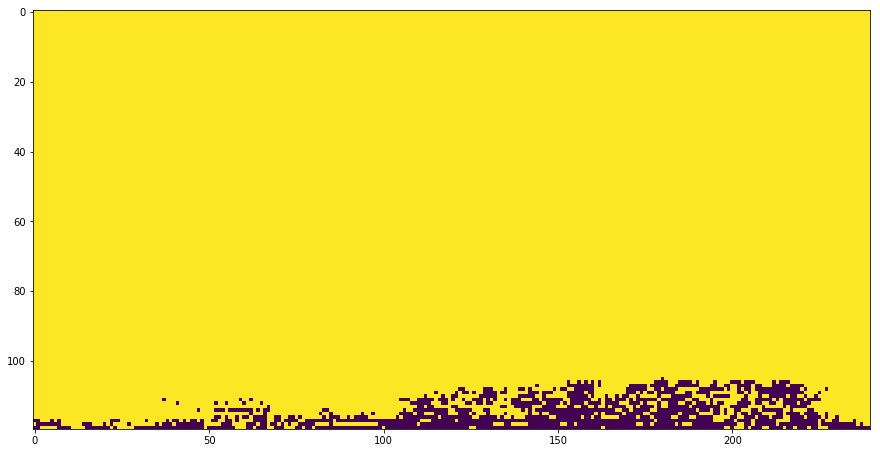

In [177]:
# run twice if not shown the first time
%matplotlib inline
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(rasteroutput)

# Issue Happens Here
### when open the output file, it looks like a different way. This can be resulted from the different NoData Values in the raster. Still working on this part.

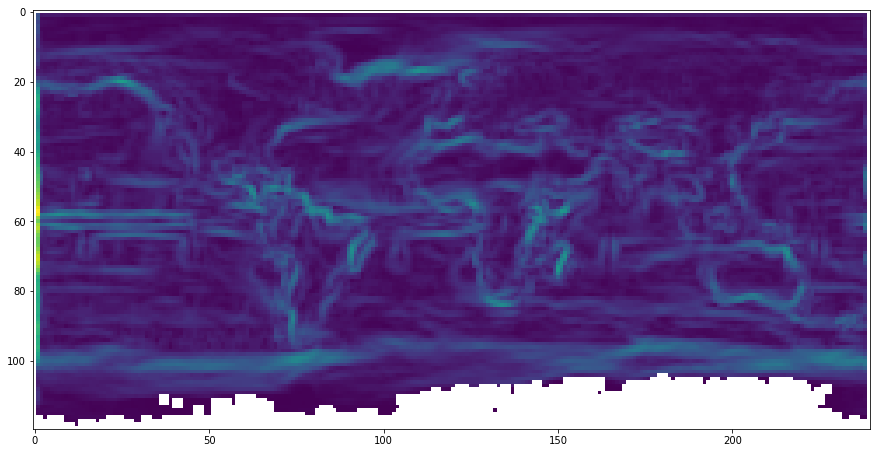

In [7]:
# run twice if not shown
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
src = rasterio.open("test.tiff")
img=src.read()
img[img == src.nodata] = np.nan
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(img)

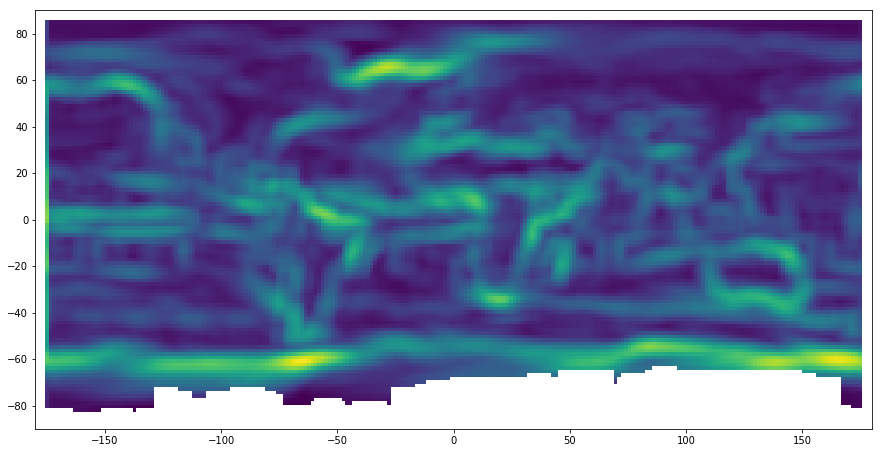

In [9]:
# run twice if not shown
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test1.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

## it is wired that if I reload the test data and plot it again, it solves the issue. It is confusing and after trying for every possibility, the issues still exists. 

In [134]:
type_raster = None
FileName = "test_of_test.tif" # output file
rasterFile = 'test.tif'
gd = gdal.Open(rasterFile)
raster = gd.ReadAsArray() #array with raster
rInfo = rasterInfo(gd)

format_raster = "GTiff"
driver = gdal.GetDriverByName(format_raster)
if type_raster != None:
    dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, dataTypesFromInt[type_raster], ['COMPRESS=DEFLATE'] )
else:
    dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, rInfo.gdalDataType, ['COMPRESS=DEFLATE'] )
dst_ds.SetGeoTransform( rInfo.geoTransform )
dst_ds.SetProjection( rInfo.projection )
print(rInfo.noDataValue)
noDataValue = gd.GetRasterBand(1).GetNoDataValue()
print(noDataValue)
print(noDataValue==rInfo.noDataValue)
if rInfo.noDataValue: dst_ds.GetRasterBand(1).SetNoDataValue( rInfo.noDataValue )
dst_ds.GetRasterBand(1).WriteArray( raster )
# Once we're done, close properly the dataset
dst_ds = None

-3.4e+38
-3.4e+38
True


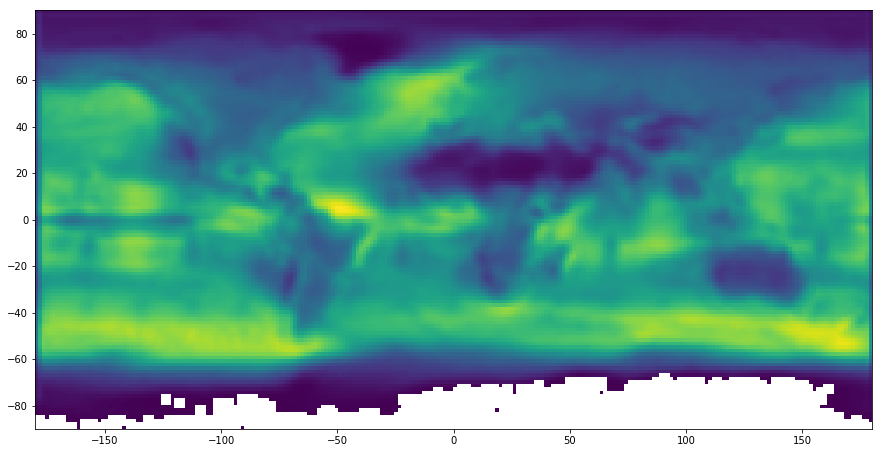

In [141]:
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test_sum.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

## Some other tests for other functions

In [136]:
raster_sum = focal_stats('rainbowdist_historical_median.tif',(3,3),"sum",output_raster_path = "test_sum.tif")

(122, 242)
The raster file has been exported to test_sum.tif


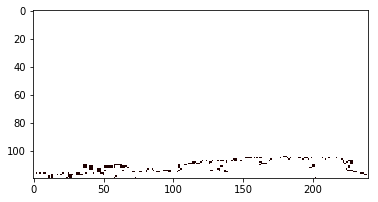

In [137]:
from matplotlib import pyplot
pyplot.imshow(src2.read(1), cmap='pink')

In [147]:
array_origin = rasterio.open('rainbowdist_historical_median.tif').read()[0]

In [157]:
array_origin[-3,13]

1.05625

In [160]:
array_origin[-4:-1,10:13]

array([[2.2714953, 2.427361 , 2.8484128],
       [1.425    , 1.       , 1.       ],
       [1.325    , 1.32     , 1.22     ]], dtype=float32)

In [156]:
raster_sum[-3,13]

-3.3999999521443642e+38

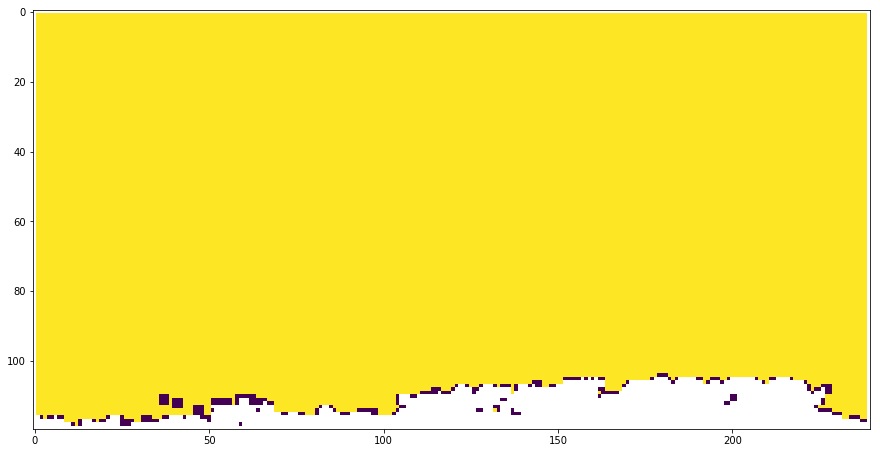

In [162]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_sum)

In [83]:
src2.shape

(120, 240)

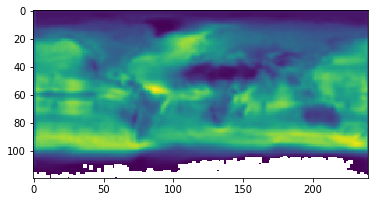

In [164]:
show(src2.read(masked=True))

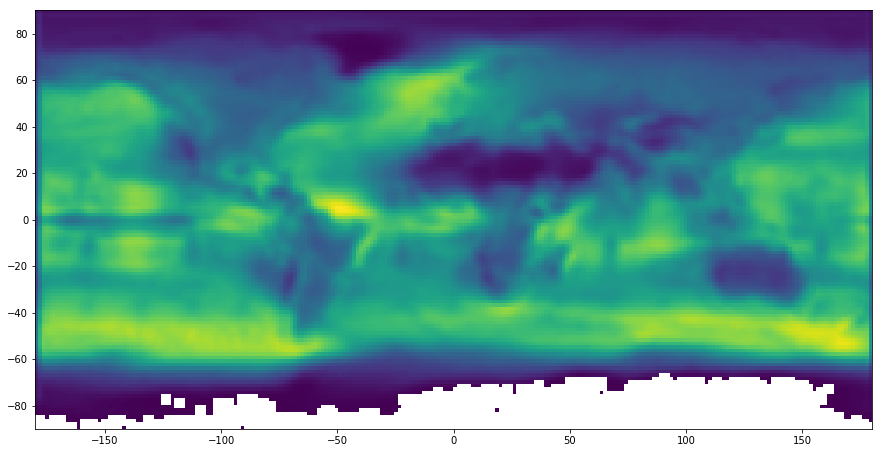

In [89]:
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test_sum.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

In [50]:
raster_range = focal_stats('rainbowdist_historical_median.tif',(3,3),"range",output_raster_path = "test_range.tif")

The raster file has been exported to test_range.tif


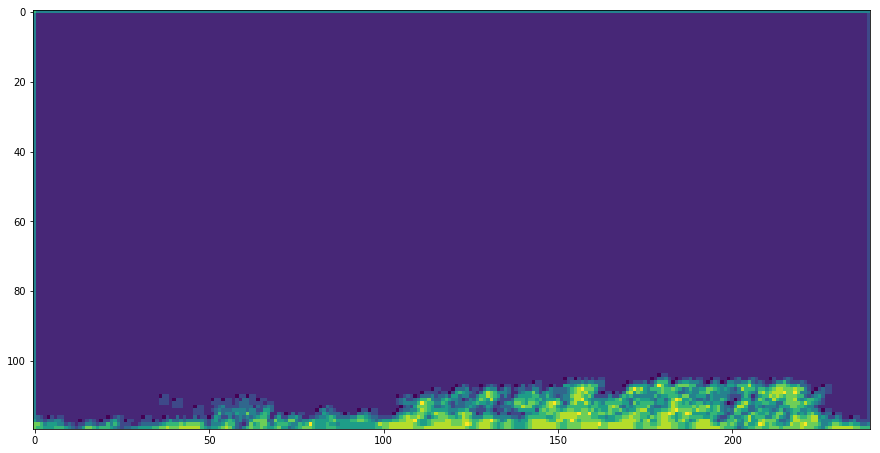

In [51]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_range)

The raster file has been exported to test_mean.tif


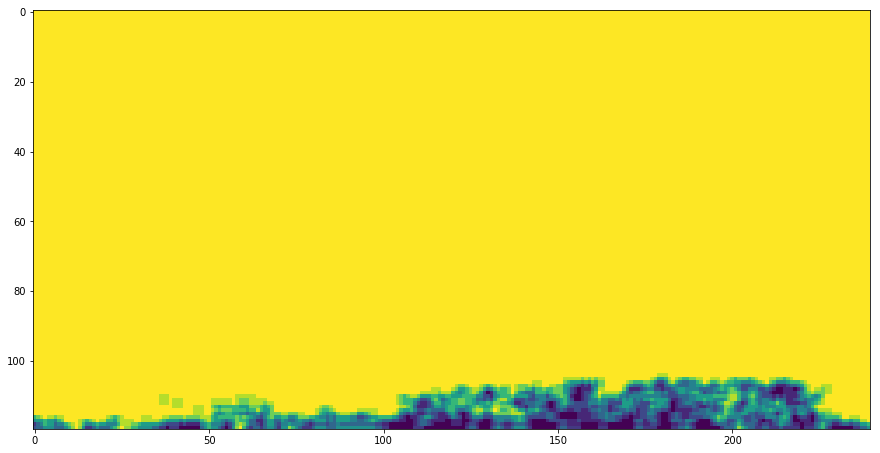

In [52]:
raster_mean = focal_stats('rainbowdist_historical_median.tif',(3,3),"mean",output_raster_path = "test_mean.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_mean)

The raster file has been exported to test_min.tif


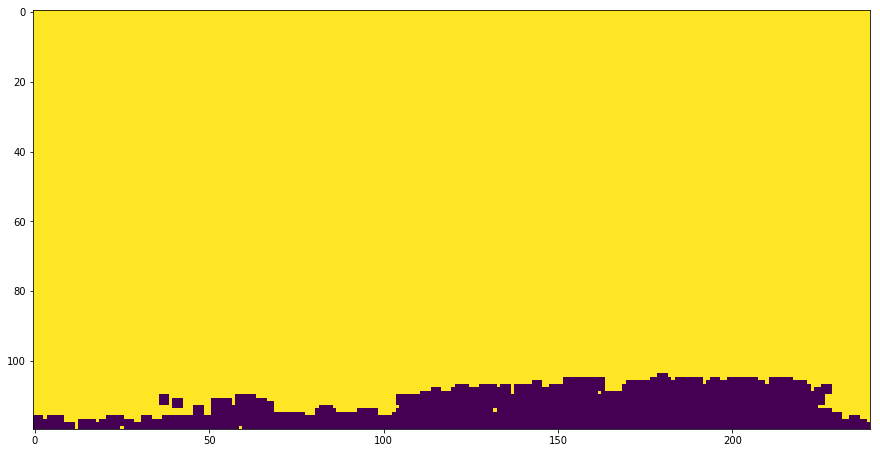

In [53]:
raster_min = focal_stats('rainbowdist_historical_median.tif',(3,3),"min",output_raster_path = "test_min.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_min)

The raster file has been exported to test_max.tif


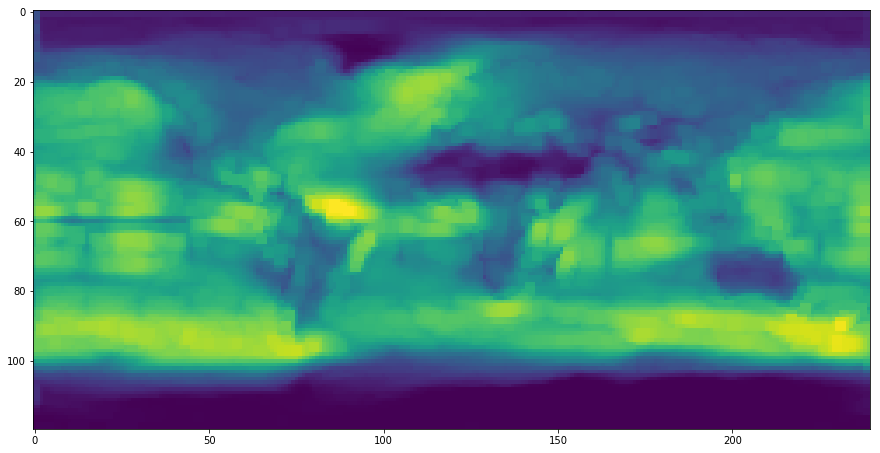

[[56.29656219 56.29656219 20.94000053 ... 20.61000061 23.5198822
  23.5198822 ]
 [56.29656219 56.29656219 20.94000053 ... 20.61000061 23.5198822
  23.5198822 ]
 [56.29656219 56.29656219 16.33022881 ... 13.93100071 18.56658173
  18.56658173]
 ...
 [ 1.17499995  1.39999998  1.82666671 ...  2.3499999   2.57285714
   2.57285714]
 [ 1.          2.9000001   2.9857142  ...  2.3499999   2.3499999
   2.0822618 ]
 [ 1.          2.9000001   2.9857142  ...  1.83028948  1.58749998
   1.58749998]]


In [54]:
raster_max = focal_stats('rainbowdist_historical_median.tif',(3,3),"max",output_raster_path = "test_max.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_max)
print(raster_max)

# below are test codes

In [13]:
#################################Test codes


# if __name__ == '__main__':
#     #liczba kolumn i wierszy musi byc nieparzysta!!!
# #     mask = np.array([[1, 1, 1],
# #                      [1, 1, 1],
# #                      [1, 1, 1]])

#     # specify the mask - can use either methods (customize by draw, like above, or use a square)
#     mask = np.ones((7,7))
    
#     # load test file
#     rasterFile = 'rainbowdist_historical_median.tif'
#     gd = gdal.Open(rasterFile)
    
#     # get raster information from the file, like coordinate systems, etc
#     rInfo = rasterInfo(gd)
#     #print dir(gd)
#     #print gd.GetRasterBand(1).GetNoDataValue()

#     #raster = gd.ReadAsArray() #array with raster
#     #r = rasterAverage(raster, mask, rInfo)
#     #print r

#     #gd = None
#     #nd = gd.GetRasterBand(1).GetNoDataValue()
#     #dt = gd.GetRasterBand(1).DataType #dataType

#     #print raster
#     #raster[raster==gd.GetRasterBand(1).GetNoDataValue()]=np.nan
#     #print raster
#     #print np.where(np.isnan(raster))

    
#     # can use f to make all results available
#     f = focal(mask, raster, rInfo)
#     #print(sum)
#     #cProfile.run('f.median()', 'C:/Documents and Settings/Pocisk/Pulpit/median.profile')
#     #cProfile.run('f.median3()', 'C:/Documents and Settings/Pocisk/Pulpit/median3.profile')
    
#     # or can give the result to variable a for processing or plotting
#     a = rasterSum(raster, mask, rInfo)

#     SaveToFile('test1.tif', a, rInfo)

In [ ]:
mask = np.ones((7,7))

# load test file
rasterFile = 'rainbowdist_historical_median.tif'
gd = gdal.Open(rasterFile)

# get raster information from the file, like coordinate systems, etc
raster = gd.ReadAsArray()
rInfo = rasterInfo(gd)

In [ ]:
if __name__ == '__main__':
#     mask = np.array([[1, 1, 1],
#                      [1, 1, 1],
#                      [1, 1, 1]])

    # specify the mask - can use either methods (customize by draw, like above, or use a square)
    mask = np.ones((7,7))
    
    # load test file
    rasterFile = 'rainbowdist_historical_median.tif'
    gd = gdal.Open(rasterFile)
    
    # get raster information from the file, like coordinate systems, etc
    raster = gd.ReadAsArray() #array with raster
    rInfo = rasterInfo(gd)
    
    # can use f to make all results available
    f = focal(mask, raster, rInfo)
    
    # or can give the result to variable a for processing or plotting
    a = rasterSTD(raster, mask, rInfo)

    # save a to test1.tif file and load in the following cells
    SaveToFile('test1.tif', a, rInfo)

In [3]:
mask = np.ones((7,7))
rasterFile = 'rainbowdist_historical_median.tif'
gd = gdal.Open(rasterFile)
rInfo = rasterInfo(gd)
u = gd.ReadAsArray()
noDataArray = np.where(u==rInfo.noDataValue)
u[u==rInfo.noDataValue]=rInfo.noDataValue
(mh, mw) = mask.shape
dx = mw//2
dy = mh//2
#wm = dx*2
#hm = dy*2
print(dx,dy)
for x in range(dx):
    u = np.insert(u, 0, rInfo.noDataValue, axis=1)
    u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

for y in range(dy):
    u = np.insert(u, 0, rInfo.noDataValue, axis=0)
    u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

(uh, uw) = u.shape
#print u, hm, wm
out = np.zeros(u.shape, dtype=rInfo.dataType)

for w in range(uw-dx-1):
    for h in range(uh-dy-1):
        s = u[h:h+mh,w:w+mw]#*mask
        s = s[np.where(s!=rInfo.noDataValue)]
        if len(s) == 0: continue #if all values are noDataValue then continue with next cell
        a = np.asarray(s).astype(np.float32)
        m = np.std(a)
        out[h+dy,w+dx] = m
        print(m)
out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue

print(out[dy:-dy,dx:-dx])

3 3
1.5944092019036409e+38
1.6710784078218629e+38
1.6996459200491666e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.68256361795594e+38
1.6

4.935405284459315
10.776105632960517
15.727336501528942
18.70049142211921
19.31229819670897
18.238548799955616
14.983797066155654
12.377969839935101
11.546008521074487
11.833378038080708
12.256492780772922
16.03464788605489
19.116671861724615
21.41498005521518
23.011944987421902
21.965603632663154
18.841964457314052
12.711263942136378
8.994558738457727
4.7746246527206315
4.9841435390437345
5.751035064012229
6.386790176057988
5.582283777251054
4.531735261397411
3.8134163980012312
4.6473992263236665
5.124960063223752
5.471670697278977
6.100874872597318
6.222316674358394
4.150619542358049
3.7970100214318365
4.236897407141293
4.213543764273204
5.0132519506723705
5.712238648681041
7.351019439348596
8.89087187744912
9.440030764823314
9.732263781367413
9.655579686814551
7.955983258739628
7.230816993727154
7.285623723921738
8.552492012125953
8.340885805696875
14.266429808381073
24.39456587547342
30.24228397207596
31.6034841030045
29.115092582704094
25.367180276033434
23.047832566165006
24.9926

3.9263351827372737
4.028183871496872
4.119518845954697
4.14734241642592
4.063488198386742
3.947534777702876
2.2611132278077033
3.941028319621542
6.504759183418604
8.525943003051445
9.102899592047182
9.014335853982923
9.421240193762895
10.482785889736231
12.221488779506705
13.05128384158958
11.491475793683296
9.33708626385215
7.242070608531221
6.943957570471682
6.554419781050964
6.823079871885833
6.833196334915155
10.393860454160373
17.952261419389103
24.25685615418999
27.035970873814517
25.41498739425896
21.74688746715129
17.0548568606607
21.856244613633542
24.40826120797412
21.89104010537997
15.644674227366632
15.038471632475446
10.924445583145346
8.802542381139393
8.87349358291269
8.795200552070286
9.12838852272171
11.845041196731858
14.32974572184817
15.565614280086187
15.560039887034204
12.623664056562045
8.769938748711043
9.090640355726126
10.903302755455817
12.286195348685629
12.660264862797694
11.084928368908239
9.359420084367148
9.358623679586206
10.437400772518636
11.574412499

15.13604811595025
21.086804384251806
24.14318175192756
23.444100108527476
21.137883077112118
15.827013175892215
9.751229610408487
5.383171180806796
4.989506223882673
12.23236083898519
20.65937945370474
26.352370241340296
29.609217973835047
27.010872068769007
21.96766912244899
18.73819970328662
24.734296145948733
27.906757537046918
25.73736122129313
17.741917906993145
15.7459341460859
8.521534211462415
8.163859220653087
7.566591814414895
6.768048707085297
7.481878383012384
11.204963886598513
14.762231959527174
17.577894005167018
19.031903779606736
17.313209896228678
11.687743866896797
6.747756375750938
5.559319221124303
6.239919503930102
7.088264114105197
7.670876528587541
7.285007380393707
8.85592758163042
11.050718458111248
13.57931208719463
15.263452514607952
15.029475710106803
14.15850603592879
11.70174550525065
8.512725043363927
6.697022989200266
7.756461064347826
11.342693124471566
16.116063908518235
19.589225358572076
21.93266317470576
23.83284015975924
27.149851092331694
30.3086

7.055035215005869
4.687736879149796
4.273263454100197
4.475678941239726
5.323351028775602
8.437754907680258
13.71991692149543
22.483273229172013
31.539917641927044
38.35897023454277
40.89978434376809
39.41811958368386
34.99956796371654
28.904215511113787
24.5869767668706
22.20219187309964
20.198359587052675
4.807324622731258e+37
6.727392360500701e+37
6.727392360500701e+37
6.727392360500701e+37
6.727392360500701e+37
6.727392360500701e+37
1.1145323633803124e+38
1.4186359845403302e+38
1.6183866255861314e+38
1.6996459200491666e+38
1.6390791670300717e+38
1.4186359845403304e+38
9.980479673853604e+37
5.66435318955146e+37
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
3.318639184777681
4.271862047234376
5.895608427360235
7.21297624884995
8.404641797578869
8.794760429201691
8.160106598486056
7.141271239226392
7.0302079870552685
8.578404188093241
10.045514218179862
11.402722320706507
11.787502833692507
11.266332260443535
10.067623673764118
9.87139467115524
11.28293642493626
1

20.598455980953283
17.85982850466481
4.807324622731258e+37
4.807324622731258e+37
9.309344101825506e+37
9.309344101825506e+37
1.1145323633803124e+38
1.316540068559961e+38
1.4186359845403304e+38
1.5944092019036409e+38
1.6968108122871702e+38
1.6911263379784432e+38
1.5669961121549762e+38
1.448120193617301e+38
1.2814022750533923e+38
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
3.7202157454716467
5.928275856304398
8.15272178195984
9.707314552885663
9.820317741746136
8.379394833621946
6.76380507741038
4.64004510430681
3.8597539780975945
4.403912430676464
6.652239432724662
8.769974386259713
9.831200085819512
10.393932115002608
10.004316680815018
8.87515066443219
7.523838544358331
6.87087866072376
6.545213489224071
5.772503195231954
5.1702661210748335
4.852166491836817
5.5601162120517
6.915425397895693
7.657749250486342
8.136568503435846
8.648903827039426
8.819385317437666
8.81736153733225
8.547020491583321
8.430149515252264
8.772514915780173
9.27684130926169
8.79880124827

22.230573177558345
21.861522756370963
21.384135091742817
20.287265369086334
25.36742617195441
32.35730401344722
33.753984684895514
30.596996304926325
24.898808618560135
16.226116469812936
8.95810228823858
9.043392224130265
11.293032393071293
14.484406935136079
17.91202067576173
19.4096651531881
18.784782737029243
16.38156975093326
13.375634193216367
11.899679654190203
12.378465046448644
13.251051342178046
13.106344188039898
12.772955903784593
13.038310492313038
13.80629944959816
14.832886227351631
15.651920350369043
15.957009802918451
15.54052803601732
14.637354820169524
13.230106753324604
11.89802785390092
10.347854023041224
8.657989512513698
7.785601131578459
8.84912537171426
11.277074090456534
13.369579111466411
13.767233724693437
12.921849231589054
10.791106941356697
8.06954193769955
6.520366212576623
5.917449256120022
5.9359173073024785
5.52326064163498
8.75632280044218
16.046123831270048
23.97948549991085
31.614132313690337
37.445837868027496
39.06020646488865
38.1036135112943
35

18.114089800436073
18.769300312860118
25.855137928164055
31.07162622800019
32.599604070573434
30.403050469846587
25.920009761133343
23.621960240785764
25.12579559905928
26.268374381691665
24.210176714465874
21.47158599505927
19.236219530495767
17.88277084121951
19.22564489100718
20.569880881874504
20.199828305740365
18.255674169683378
14.680847696887163
12.94669001070266
12.766582530787412
13.32543096902313
14.170085480039761
14.042438546287785
15.166962094011723
15.940520856353588
14.984209906775579
13.247150098882072
12.237254286738544
9.176828504456003
8.508677608223723
10.98579393756637
14.877941303128674
18.40388198678027
22.1711255136503
25.983699318797264
28.21633046228946
29.081518929501616
28.38854077475948
25.87813640816206
22.719256739346083
18.924684701381214
15.448310515165433
12.867665272590498
11.922275440048477
12.302419424666919
12.327938452881453
12.13993346653349
11.197753170839423
9.838118109534992
10.897474846755603
18.74781765960094
27.9820882031479
36.97947365358

6.616309470520467
10.569650916998468
17.572245897456124
26.14232269955799
29.377883850747352
31.03439031369798
31.796785768844895
32.48787377699811
32.62825318054783
31.37730969979723
25.77192370217328
21.14793391998461
16.39339517962343
14.26282464291734
14.147972280703328
13.84834759358068
12.90495450107425
11.264511206504194
9.172429697668964
8.226601888259207
8.332155067036487
8.14234735392438
8.736264420755111
9.724637072402798
11.049072812635233
12.173460725698867
12.726490691526603
12.556896638900612
12.405764117600757
11.848266105533092
10.99241711567048
9.873163565089373
8.687749558661809
7.776298341757578
7.699540759960485
8.270313915438896
9.08015801444172
10.245223976438432
11.402807519551274
12.766499416463809
15.34181665452581
19.77045017251819
23.593738761379512
27.403674372167046
29.71870948609092
30.236381977212854
27.24459640333233
21.124839934302006
21.500734045380998
31.785749888451267
43.77890955353134
52.61564175275068
55.529868702601654
51.03533031568936
42.72768

41.865663826078006
44.993933260282176
41.58736883237885
34.324537585295246
25.987273042061542
17.839391242539634
12.39266864280616
10.390458378239053
8.947029551576573
6.674173233906686
4.254591686053557
3.261876393765563
2.7784042023039
6.727392360500701e+37
9.309344101825506e+37
1.2566656749516736e+38
1.5359634133199545e+38
1.5669961121549764e+38
1.6911263379784434e+38
1.6710784078218629e+38
1.5669961121549762e+38
1.370298348828041e+38
1.2671051694151383e+38
1.2814022750533923e+38
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
5.175023905875128
6.500912830698045
7.999695089295427
8.966114846642236
8.714484131811686
7.8846837477865614
8.23844165194957
11.306027744328116
13.84264880061787
15.678132132956828
16.865054139806187
17.59559015969383
18.266704185200823
19.758564296990645
22.350238823929864
24.34159220736949
24.464487589631354
22.345868806899254
17.90670969852474
11.514998668885257
8.65740574563213
8.168820614332446
7.568408740195815
7.987780856822338
9.912

22.937679004356365
25.649367004374728
26.932267080525317
26.576602217155187
23.963224681704823
20.527882218516567
16.888661878526932
12.481419379047097
9.635990030811048
8.474203637304457
8.156536334193827
7.355205557104517
6.4352458063265
6.066063368485423
5.591168349640887
4.532105823822719
3.1742142080005786
6.727392360500701e+37
1.0291867143354434e+38
1.4620907043064856e+38
1.5010866323304017e+38
1.6710784078218629e+38
1.6911263379784432e+38
1.5669961121549762e+38
1.3702983488280413e+38
1.1897521440344168e+38
1.2814022750533923e+38
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
5.058318417011021
6.479133166946166
7.553783709248234
8.354833535114972
8.154508220017421
6.038492336259776
2.567412124461286
1.8521007009759534
3.462422617457024
10.62719944464033
19.973437625470392
30.546057385138116
40.544647705326966
46.67435874033775
47.765396118855776
43.496390634019434
34.871067252455866
25.81823334445519
17.842755845466357
12.461210732710803
10.758600753155104
10.

14.221696255749128
17.475158804721836
20.41805742693672
23.079962496810893
24.883567371921362
25.41752089237911
24.715387869522253
23.35026422938491
21.007533398298904
18.056574589151616
15.58953371455869
15.382507757525495
16.281775243160478
16.452049743134925
15.17723256546587
13.143694899683496
11.162575322630211
11.151448227896593
14.75395607352798
20.728054007408208
24.25940994921078
25.91671498292786
25.141310987685703
22.909136975724405
17.583723312344166
11.066641386978771
10.22301094203506
14.376907967708467
18.57779058014499
20.93339444647995
20.41690983659132
17.13881108083653
14.679927209451403
11.595747388092219
9.692158827088383
8.557090914729013
8.094881921246502
9.099134280869698
9.865201168204349
9.82675567949544
8.84780807172435
6.909132634305608
5.319045202393276
3.74653796257514
3.105203827260047
3.010231692903294
4.4690145676070365
5.576634458385584
6.572603699349982
9.0209190984959
10.563028537174617
10.506188549984078
8.667264665331999
7.021237618612962
5.0178038

9.684542575850408
11.66936376981054
12.726673434631287
11.544613839471884
9.655347155478177
8.405191373970728
8.456389215254282
10.827056412119354
13.567870220597277
16.298730855504452
19.524104435836204
22.2588037345937
24.27697194928694
24.913225118083197
24.081058987953966
21.45379195770856
18.154029904234058
15.281803319739268
13.589306804891525
12.871589973797144
13.428638776528821
14.676378648988212
14.85874879408253
4.807324622731258e+37
6.727392360500701e+37
1.1897521440344166e+38
1.3702983488280413e+38
1.4620907043064856e+38
1.639079167030072e+38
1.6911263379784434e+38
1.6911263379784432e+38
1.6183866255861316e+38
1.5669961121549762e+38
1.4186359845403304e+38
1.1145323633803126e+38
1.0291867143354434e+38
6.727392360500701e+37
5.1834814525824055e+37
0.0
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
4.592478689044114
6.468464303060371
8.879396767448817
10.849412326785648
12.155757924870006
13.328196881271623
14.530287954019292
16.646624245571886
18.811399274

23.48227186086291
26.676979041116557
27.00691465339627
25.058240472845547
20.884142118738744
16.0857382135267
14.695678494125987
15.227674813990976
16.411826068119282
16.956883354072946
17.746333265183644
6.727392360500701e+37
1.1145323633803124e+38
1.2566656749516736e+38
1.4620907043064856e+38
1.5944092019036409e+38
1.5944092019036409e+38
1.6710784078218629e+38
1.68256361795594e+38
1.6911263379784432e+38
1.6911263379784432e+38
1.6566099241712848e+38
1.639079167030072e+38
1.4186359845403304e+38
1.2566656749516736e+38
9.309344101825506e+37
7.240600968086504e+37
7.891922910566069e+37
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
4.352861185316595
7.590600939503662
12.35483765052123
17.707375387847474
23.00086924490099
26.871452538901334
27.862219720837903
26.35616251123869
23.325145387894132
21.064504177435325
19.021607693741615
16.488215656303982
15.659602548345784
15.16034358999386
14.82434510005633
15.16836331192084
14.957716029338586
14.308858171730718
13.6656770

7.996984857724018
8.397646478623642
9.09902849681132
9.700295202732109
10.85558963661691
12.198188998848012
13.476719102401669
13.402344644150347
13.990043619767984
15.7753048250741
16.898094712490845
16.792649237287264
16.562529936392067
17.418819422082166
18.721279132838603
20.91157690598787
23.6981220163516
29.093092590553145
32.63290383061776
30.314599041948913
24.75839021968665
19.64775133412439
15.98525209779098
12.42535861827858
13.524584201300101
10.984620345018817
6.444803396464248
6.606207732871904
6.47511986576945
11.488502659179195
16.909459312719104
21.49559781801625
25.619959225460814
27.701451440759488
27.319000257795985
23.96233761523549
21.516933459339047
19.296100918757283
17.206319216229335
17.582887267872223
18.523479962110823
8.151215481841643e+37
1.0291867143354434e+38
1.1897521440344168e+38
1.4186359845403304e+38
1.5669961121549766e+38
1.6710784078218629e+38
1.68256361795594e+38
1.6566099241712848e+38
1.6566099241712848e+38
1.6996459200491666e+38
1.69112633797844

13.103046015711083
15.509886274546405
18.719725859696897
21.930704668157077
23.68632774389219
23.122467360470246
20.500738869952112
19.93111322216555
19.800982437046105
17.222762076411215
12.994092973029566
8.497650345172941
5.064182504527123
4.988014523249988
8.53035904141218
12.780910901043752
16.814738136528675
18.958824358515024
21.5087750814134
23.72356279139562
24.508447519046825
24.99802227740163
23.226992681189923
22.467011263854662
22.33660782991643
23.44360030615226
27.09311199900345
31.90614883296396
34.60294445222643
33.59271082966583
28.86099354114734
21.0901975866155
13.129129753813347
13.11449952455517
17.588623427857257
20.269484173875295
21.298768047728906
21.328007330307727
21.562844547803135
20.12937526347779
18.522210644245536
17.203721685992953
14.782778182720994
12.63376247008597
12.855215419629182
14.208369283491358
14.765623224618352
12.811295469915889
10.226934952038414
9.887881660634465
12.421875062278344
14.77661171142069
15.159154420032417
13.829363846288594

14.939787126966058
15.179143159962168
16.133051785801932
16.448751942285487
15.79638622085502
15.071602654420513
14.095747009740323
13.083465578977394
11.138227278577991
9.172357824299787
7.184927361582225
5.43850147392805
6.003846028435096
9.276835555520552
12.59198916757626
14.011320937627163
14.093544310992703
12.258692266484276
9.60386399776933
7.026279705431438
5.986684774324168
6.027129815488436
5.268725575155458
5.683159280353973
9.36611079742274
13.498723990558892
16.679140611830096
17.64881507198854
15.477208246091868
10.529288528977922
7.7556895253692115
7.401541439028992
7.393642310790362
7.59170269573858
8.256945655881216
7.994308365975683
8.056921098270893
11.70938221859637
17.585086434330922
23.59451228503215
29.50824070470215
33.20402256660436
35.86303023348767
38.22313730374958
38.37140811681772
34.750952748547206
8.151215481841643e+37
1.3702983488280413e+38
1.5944092019036409e+38
1.6911263379784434e+38
1.6825636179559403e+38
1.5669961121549762e+38
1.3165400685599608e+3

11.62158613478035
9.419523057431833
6.150216457080573
4.315868862721773
3.3997458857581133
3.2327883856398105
4.633371980906056
7.306350661596915
11.142290344169341
15.251708245905302
19.374722627273382
20.21991756718657
18.081857514804284
14.241572642268295
10.502020003753495
8.725672880172963
8.347234305063079
8.101504755774942
6.9583802441882066
6.680007415899541
12.039170794531993
21.250754805943682
29.549877219245797
35.28266162629198
37.627223092267464
37.191206533819305
34.56496423872622
30.671405738558487
27.6126632984063
24.51332427436912
20.295335845989975
4.807324622731258e+37
6.727392360500701e+37
1.1145323633803124e+38
1.4186359845403302e+38
1.5669961121549764e+38
1.6710784078218629e+38
1.6996459200491666e+38
1.6566099241712847e+38
1.6183866255861314e+38
1.5359634133199545e+38
1.462090704306486e+38
1.3165400685599608e+38
1.1897521440344166e+38
1.0291867143354434e+38
9.309344101825506e+37
0.0
0.0
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
4.304647359

21.958261725248647
25.112346155368567
23.95143847733612
19.882281707550604
15.765374913678215
13.165442415056376
13.161815882971982
12.644245296521973
12.318186980951232
13.352922259764744
14.873083230142012
16.697180527464408
18.074654423628896
19.39237730749873
19.02239639236823
17.26877935362576
14.317106039869877
12.10204024495001
10.526136647924298
8.993734765863218
7.972000118741121
7.769103740731119
8.733402073928175
9.385864649929447
12.020844911752057
11.948064294847606
10.405869224190257
8.59090372164852
9.284136234096701
14.496431058658438
19.94221539566344
21.885268735558583
22.41637763628299
20.412118517412324
16.48714553654184
12.017249770208503
8.248527427123442
5.900006006212425
6.072804041855802
7.429931756429145
8.681383420617433
9.04624847525008
9.526068002973144
11.146470307265464
14.20306339149587
17.87992496502353
19.36798354579136
19.314758253980155
16.305759833504133
11.980468408933987
8.224969992143642
5.316371130089869
7.206023967567457
14.316800201771951
23.7

1.6911263379784432e+38
1.6183866255861316e+38
1.5669961121549762e+38
1.5010866323304017e+38
1.370298348828041e+38
1.3702983488280413e+38
1.316540068559961e+38
1.4186359845403304e+38
1.316540068559961e+38
1.2566656749516736e+38
1.2566656749516736e+38
1.1897521440344166e+38
9.980479673853604e+37
1.0817370609813242e+38
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
3.359660321436938
4.828468903980009
8.021024034183553
10.15765884709436
11.493807246505474
11.952150607888143
10.831306260125286
8.88896059508781
7.7200482043556455
7.809615532021904
7.904462875019344
8.019167224643228
7.358929926716482
6.301935978979235
4.897376093263119
4.155813611889599
3.990375207433546
4.548247689668169
4.536178006456371
4.158839748404628
3.704719807468093
3.3803505341256552
3.8783816136133833
5.388531462464874
9.320704973657536
13.554014606041516
15.7434138723198
14.608313162411386
13.785587115912055
13.105827316700841
13.165165559077531
14.027553485464658
13.436124650182382
11.2136786

1.5944092019036409e+38
1.5359634133199545e+38
1.5010866323304017e+38
1.4186359845403304e+38
1.1145323633803126e+38
8.756338688594013e+37
0.0
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
3.0440337146183842
3.223764102873509
6.424228240398911
8.388636925930118
10.586710372615245
11.516879440795337
10.522808774883693
8.742418235254611
6.975394793111469
6.832017223096778
6.425627614911566
7.00098361131025
6.892779729862762
6.35035670442587
5.513684413818293
4.3902960295639435
3.622543066877922
3.1209992500501293
2.957163068967978
2.7225617841161176
2.6551775701978646
2.5715691194830774
2.6191446144327877
3.2615111097439278
4.3526505954803545
4.862615041870146
5.10975010769951
5.3232276322067476
5.408521517157538
5.706360614035993
6.287263926565459
6.46981699631596
6.227112843341155
6.389016922841261
6.263898153967082
5.432443117402173
5.8778912955592695
9.04860439027303
10.913498853423064
12.524177109631497
14.001073918801536
13.92714646950635
12.180638744274477
10.77

3.038323326960639
3.4267877105874125
3.4860844993074305
3.5540092545868696
3.32390387529957
2.6659452856470547
2.6913416700826516
2.983945839920544
4.34723513336901
5.27757556736239
6.870311143355116
9.320435108644624
11.387559332275396
12.744425692811621
13.109425720959331
13.986871921841464
16.088760629998102
18.968794526922018
20.506335120375553
21.6071742471342
22.999525009694366
21.916525774116156
18.485489409188908
14.858957263607794
12.053769284552155
9.684896468113953
7.17739487298137
7.064569564194064
10.195215342349867
12.919026218926838
15.686769775362707
18.494726776671897
18.708759324561093
18.660723330470596
18.65096710886597
19.473860122830366
19.755687913957598
19.491265138089595
17.987421116697046
16.23401058022203
14.699887419269542
13.914175858530538
12.89781129638799
11.923628790180869
14.968610149301076
21.662003919154124
25.79943016758959
27.3997917655827
26.565270623771422
21.909381550635302
15.863652084570619
11.771132149526995
9.773255595456734
7.15405946965330

1.3702983488280413e+38
1.5010866323304017e+38
1.5359634133199545e+38
1.5944092019036409e+38
1.639079167030072e+38
1.639079167030072e+38
1.6183866255861316e+38
1.5359634133199545e+38
1.370298348828041e+38
1.3165400685599608e+38
1.2671051694151383e+38
9.518017152275333e+37
1.68256361795594e+38
1.5359634133199547e+38
1.1897521440344168e+38
2.599354112625349
1.899443780860517
2.4778269699693745
6.0823053027515055
8.403937314251426
10.136548005820222
11.037239688830502
11.068589772860514
9.512798661680508
7.047793016471927
6.2400072839186365
6.324551053555267
5.429737346301942
4.441435399485435
4.525833219308432
4.862206232768803
5.13757125197416
5.758908842288761
6.127476938524996
7.4195518183235425
8.416876604072279
8.413852718790029
8.036663433556779
8.802480332611326
10.79633678316715
13.435260434096392
19.503805308365592
24.81175483774703
27.04104273391028
27.35022810907089
25.520587767393373
21.486784007005177
14.144446227102563
11.347242307340608
12.987221456105441
14.692880777873862

4.695048502350431
4.9407829471599
6.673565480995685
8.784748497361566
11.299437826008628
13.159933973569117
14.252074430624543
13.97842727513541
13.532926991976725
12.955853862161346
12.875584310555036
11.819782097836951
11.38613086996612
13.646783271612748
16.409251527448816
17.834046099678954
18.718762306628612
17.102997455512433
13.207675476135096
7.991688479289774
7.572121756369489
11.07631474855363
13.0398560039624
11.180889986309694
8.966703436044083
7.551797293543518
8.069698631008734
9.275300299303005
8.868012592256662
7.076043501369683
6.383612354527117
6.149795945915881
5.965592036547068
6.089589721651717
6.2738585045517254
6.027834726486443
6.364040542999744
7.087803598504885
7.618744077495056
7.49145888235538
7.81769339946868
6.742048085177963
5.140623998573424
4.945913420100483
5.85795693705288
6.065725727104706
5.515023114185459
6.717936532944624
8.201649677481077
9.584061299713685
11.586494578151294
13.296500651385745
14.085150498637175
14.059567726818912
13.859583899989

1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.1897521440344168e+38
1.189752144

In [19]:
help(f)

Help on focal in module __main__ object:

class focal(builtins.object)
 |  focal(mask, raster, rInfo)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mask, raster, rInfo)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  average(self)
 |  
 |  mask_count(self)
 |  
 |  max(self)
 |  
 |  median(self)
 |  
 |  min(self)
 |  
 |  raster_range(self)
 |  
 |  sum(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
# class focal
class focal(object):
    def __init__(self, mask, raster, rInfo):
        self.noDataValue = rInfo.noDataValue
        self.dataType = rInfo.dataType
        self.maxValue = rInfo.maxValue
        self.minValue = rInfo.minValue


        #print self.noDataValue, self.dataType, self.maxValue, self.minValue

        self.mask = mask #user mask
        (self.mh, self.mw) = self.mask.shape

        self.size_x = self.mw//2
        self.size_y = self.mh//2

        tmp = np.array(raster, dtype=self.dataType)
        for x in range(self.size_x):
            tmp = np.insert(tmp, 0, self.noDataValue, axis=1)
            tmp = np.insert(tmp, tmp.shape[1], self.noDataValue, axis=1)

        for y in range(self.size_y):
            tmp = np.insert(tmp, 0, self.noDataValue, axis=0)
            tmp = np.insert(tmp, tmp.shape[0], self.noDataValue, axis=0)
        #print tmp
        self.big_r = tmp
        #print self.big_r
        (self.h, self.w) = self.big_r.shape


    def sum(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=0

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        wm = dx*2
        hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        #print u

        for x in range(wm):
            for y in range(hm):
                if mask[y,x] != 0:
                    out[dy:-dy, dx:-dx] += (u[y:y-(dy+1*dy), x:x-(dx+1*dx)])#*np.array([mask[y,x]])

        for x in range(wm):
            if mask[-1,x] != 0:
                out[dy:-dy, dx:-dx] += u[(dy+1*dy):, x:x-(dx+1*dx)]#*np.array([mask[-1,x]])

        for y in range(hm):
            if mask[y,-1] != 0:
                out[dy:-dy, dx:-dx] += u[y:y-(dy+1*dy), (dx+1*dx):]#*np.array([mask[y,-1]])

        if mask[-1,-1] != 0:
            out[dy:-dy, dx:-dx] += u[(dy+1*dy):, (dx+1*dx):]#*np.array([mask[-1,-1]])

        #print out[dy:-dy,dx:-dx]
        #print out
        out[self.big_r==self.noDataValue] = self.noDataValue
        #print out
        #print self.big_r
        return out[dy:-dy,dx:-dx]

    def average(self):
        out = np.array(self.sum()/self.mask_count(), dtype=float)
        out[self.big_r[self.size_y:-self.size_y, self.size_x:-self.size_x]==self.noDataValue] = self.noDataValue
        return out

    def max(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=self.minValue
        #print u

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        #wm = dx*2
        #hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        for x in range(mask.shape[1]):
            for y in range(mask.shape[0]):
                if mask[-(y+1),-(x+1)] != 0:
                    out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

        out[self.big_r==self.noDataValue] = self.noDataValue
        return out[dy:-dy,dx:-dx]

    def min(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=self.maxValue
        #print u

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        #wm = dx*2
        #hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        out[:,:] = self.maxValue #np.nan_to_num(u).max()+1
        #print u
        #u[np.isnan(u)] = np.inf
        #print out
        for x in range(self.size_x):
            u[:,x] = u.max()+1
            u[:,-(1+x)] = u.max()+1
        for y in range(self.size_y):
            u[y,:] = u.max()+1
            u[-(1+y),:] = u.max()+1


        for x in range(mask.shape[1]):
            for y in range(mask.shape[0]):
                if mask[-(y+1),-(x+1)] != 0:
                    out[dy:-dy, dx:-dx] = np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

        out[self.big_r==self.noDataValue] = self.noDataValue
        return out[dy:-dy,dx:-dx]

    def raster_range(self):
        return self.max()-self.min()

    def mask_count(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        #u[u==self.noDataValue]=0

        dx = self.size_x
        dy = self.size_y
        wm = dx*2
        hm = dy*2
        out = np.zeros(u.shape, dtype=float)

        c = list(self.mask.flatten()).count(0)
        out[hm:-hm,wm:-wm] = self.mask.size-c

        for x in range(dx):
            c = list(self.mask[:, dx-x:].flatten()).count(0)
            out[hm:-hm,x+dx] = self.mask[:, dx-x:].size-c
            #print c

            c = list(self.mask[:, :dx+1+x].flatten()).count(0)
            out[hm:-hm,-(x+1+dx)] = self.mask[:, :dx+1+x].size-c

        for y in range(dy):
            c = list(self.mask[dy-y:, :].flatten()).count(0)
            out[y+dy,wm:-wm] = self.mask[dy-y:, :].size-c

            c = list(self.mask[:dy+1+y, :].flatten()).count(0)
            out[-(y+1+dy),wm:-wm] = self.mask[:dy+1+y, :].size-c

        for x in range(dx):
            for y in range(dy):
                #lewy gorny
                c = list(self.mask[dy:, dx-x:].flatten()).count(0)
                out[y+dy, x+dx] = self.mask[dy:, dx-x:].size-c

                #prawy dolny
                c = list(self.mask[:dy+y+1, :dx+x+1].flatten()).count(0)
                out[-(y+1+dy),-(x+1+dx)] = self.mask[:dy+y+1, :dx+x+1].size-c

                #lewy dolny
                c = list(self.mask[:dy+y+1, dx-x:].flatten()).count(0)
                out[-(y+1+dy), x+dx] = self.mask[:dy+y+1, dx-x:].size-c

                #prawy gorny
                c = list(self.mask[dy:, :dx+x+1].flatten()).count(0)
                out[y+dy, -(x+1+dx)] = self.mask[dy:, :dx+x+1].size-c

        #print out
        #if list(self.mask.flatten()).count(0) != 0:
        #rast_nan = np.where(np.isnan(u[dy:-dy,dx:-dx]))
        #rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx) #dopasowanie do duzego rastra
        #rev_mask = np.fliplr(mask[::-1])

        rast_nan = np.where(u[dy:-dy,dx:-dx]==self.noDataValue)
        #print rast_nan
        rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx) #dopasowanie do duzego rastra
        rev_mask = np.fliplr(self.mask[::-1])



        for i in range(rast_nan[0].size):
            ry = rast_nan[0][i]
            rx = rast_nan[1][i]
            out[ry-dy:ry+dy+1,rx-dx:rx+dx+1] -= rev_mask

        #out[self.big_r==self.noDataValue] = 1
        #print out[dy:-dy,dx:-dx]
        return out[dy:-dy,dx:-dx]


    def median(self): #prawie 2x szybsze od median1
        u = self.big_r
        #mask = self.mask
        dx = self.size_x
        dy = self.size_y
        wm = (dx*2)+1
        hm = (dy*2)+1

        out = np.zeros(u.shape, dtype=float)

        for w in range(self.w-dx-1):
            for h in range(self.h-dy-1):
                s = u[h:h+hm,w:w+wm]#*mask
                s = s[np.where(s>0)]
                if len(s) == 0: continue #if all values are noDataValue then continue with next cell                
                p = list(s)
                p.sort()
                l = len(p)
                l2 = l//2

                if l%2:
                    m = p[l2]
                else:
                    m = float((p[l2])+p[l2-1])/2
                out[h+dy,w+dx] = m


        return np.array(out[dy:-dy,dx:-dx], dtype=float)